# 📚 TensorFlow基础教程【5.5 曲线拟合】


能今天做好的事就不要等到明天。以梦为马，学习趁年华。


通过最简单的神经网络曲线拟合案例，展现人工智能应用开发的全过程，包括数据集制作、网络搭建、网络训练、网络评估及结果预测。

## 一、本节目标
        本节主要通过Keras自定义搭建神经网络实现曲线的全过程，帮助大家理解Tensorflow2.0开发项目的过程，同时对Tensorflow2.0有一个整体认识。

## 二、 项目内容
曲线拟合是指给定输入数据，经过网络的计算，输出预测值。本项目中网络拟合的二次曲线为：  
$$y=x^2-4x+\Delta$$

其中x 为输入，y为输出， $\Delta$为随机噪声。

In [1]:
#导入头文件
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime

### 2.1 网络搭建
     网络搭建在此不完全借助Keras接口，损失函数与优化器部分采用自定义的方式。实现过程如下：

In [10]:
def creata_net():
    """使用keras新建神经网络
    参数:
        无
    网络结构：
        输入数据：100*1
        输入层-隐藏层1： 1*10
        隐藏层1—隐藏层2:  10*5
        隐藏层2—输出层   ：5*1
        输出数据：100*1
    返回:
        model: 神经网络实例
    """
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(
            10,
            activation=tf.nn.relu,
            input_shape=(1,),
            name="layer1"
            ),
         tf.keras.layers.Dense(
            5,
            activation=tf.nn.relu,
            input_shape=(1,),
            name="layer2"
            ),
        tf.keras.layers.Dense(
            1,
            name="outputs"
            )
    ])
    return model

### 2.2 训练网络
搭建完成网络结构后，需要通过对网络参数的学习更好的拟合曲线特征，实现预测功能。

#### 2.2.1 生成训练数据
  神经网络的训练需要大量的数据，在此拟合问题中，我们通过专业的数据处理模块——numpy进行数据的生成。

In [2]:
def gen_datas():
    """生成数据
    参数:
        无
        为了表达训练过程，生成的模拟数据需要加入噪声
    返回:
        inputs: 输入值（自变量）
        outputs: 输出值（因变量）
    """
    # 输入数据
    inputs = np.linspace(-5, 5, 100, dtype=np.float32)[:,np.newaxis]
    # 噪声数据 符合正态分布
    noise = np.random.normal(0, 0.05, inputs.shape).astype(np.float32)
    # 输出数据
    outputs = np.square(inputs) -4*inputs + noise
    # 返回数据
    return inputs, outputs

Numpy相关函数介绍

<img src="https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161841017564963401618410175949.png"/>

#### 2.2.2 训练网络
训练是主要任务是让神经网络学习上述生成数据的规律， 其过程就是逐步更新网络参数，使网络具有预测曲线值的能力。训练开始前需要定义优化器和损失函数，故又可将训练过程分为：计算损失值、获取优化变量和更新网络参数三部分。   
1）计算损失  
损失值是通过损失函数得来的，在此选用均方差（Mean Squared Error,MSE）损失函数。  

In [3]:
def loss(model, inputs, outputs):
    """计算损失函数值
    参数:
        model: 神经网络实例
        inputs: 输入数据
        outputs: 输出数据
    返回:
        loss_value:
    """
    # 神经网络推理计算：
    pre = model(inputs)
    # 计算损失值
    #自定义方法
    # loss_value = tf.reduce_mean(tf.reduce_sum(tf.square(outputs-pre)))
    mse = tf.keras.losses.MeanSquaredError()
    loss_value = mse(outputs, pre)
    # 返回损失值
    return loss_value

2) 获取优化变量  
该过程是目的是获取网络中的训练变量，便于优化器更新训练参数。

In [4]:
def grad_loss(model, inputs, outputs):
    """计算损失函数值及获取梯度优化对象
    参数:
        model: 神经网络实例
        inputs: 输入数据
        outputs: 输出数据
    返回:
        loss_value: 损失值
        tape.gradient: 损失梯度优化对象
    """
    # 梯度优化
    with tf.GradientTape() as tape:
        # 计算损失值
        loss_value = loss(model, inputs, outputs)
    # 返回数据
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

3）优化损失函数  
该过程是主要目的是更新网络参数。在此为防止出现梯度爆炸的情况，使用Adam优化器促进网络快速收敛。

In [5]:
def optimizer_loss(model, inputs, outputs):
    """优化器
    参数:
        model: 神经网络实例
        inputs: 输入数据
        outputs: 输出数据
    返回:
        loss_value: 损失函数值
    """
    # 优化器：Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # 损失值及获取梯度优化对象
    loss_value, grads = grad_loss(model, inputs, outputs)
    # 损失函数优化，更新训练变量
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # 返回数据
    return loss_value

4）训练神经网络  
网络训练的过程就参数迭代更新的过程，在此需要指定训练次数，模型保存路径等信息。实现代码如下：

In [6]:
def train_model(model,inputs, outputs, model_path):
    """训练神经网络
    参数:
        model: 神经网络实例
        inputs: 输入数据
        outputs: 输出数据
        model_path: 模型文件路径
        log_path: 日志文件路径
    返回:
        无
    """
    # 迭代次数
    num_epochs = 1800
    # 输出计数
    n = 0
    # 开始迭代计算
    for epoch in range(num_epochs):
        # 损失均值对象
        epoch_loss_avg = tf.keras.metrics.Mean()
        # 预测值与真实值差的绝对值平均
        epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
        # 计算损失值
        loss_value = optimizer_loss(model, inputs, outputs)
        # 损失值均值
        epoch_loss_avg(loss_value)
        # 更新偏差
        _ = epoch_accuracy.update_state(outputs, model(inputs))
        # 每训练300次，输出一次结果
        if epoch % 300 == 0:
            pre = model(inputs)
            n += 1
            plt.subplot(2,3,n).set_title("Figure{}".format(n))
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            plt.plot(inputs, pre, "r")
            plt.scatter(inputs, outputs, s=2, c="b")
            plt.xlabel("input")
            plt.ylabel("output")
            plt.title(" train{}times".format(epoch))
            print("epoch:{}, loss:{:.3f}, accuracy:{}".format(
                epoch, epoch_loss_avg.result(), 1-epoch_accuracy.result()
            ))
        # 保存模型
        model.save_weights(model_path)
    plt.savefig("./result_train.png", format="png", dpi=300)
    plt.show()

开启训练的主程序为：

20210414-22:12:37
inputs shape: (100, 1)
outputs shape: (100, 1)
epoch:0, loss:257.129, accuracy:-9.439844131469727
epoch:300, loss:32.224, accuracy:-3.092864990234375
epoch:600, loss:5.640, accuracy:-1.043654203414917
epoch:900, loss:2.424, accuracy:-0.34048032760620117
epoch:1200, loss:1.971, accuracy:-0.19972097873687744
epoch:1500, loss:1.464, accuracy:-0.025240063667297363


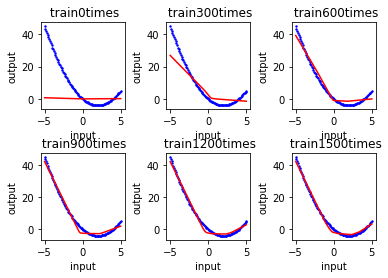

In [11]:
# 时间戳
stamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print(stamp)
model_path = "./models/mid/line-fit-mid" +stamp
# 生成数据
inputs, outputs = gen_datas()
# 获取数据维度
print("inputs shape: {}".format(inputs.shape))
print("outputs shape: {}".format(outputs.shape))
# 新建网络模型
model = creata_net()
train_model(model, inputs, outputs, model_path)

训练过程中每训练300次就保存一次模型，并输出当前的损失值和模型的预测精度。训练过程中的拟合效果打印的效果图所示。

## 四、作业
1、调整训练参数，重新训练出一个高精度的预测模型。   
2、自行完成Keras神经网络的搭建及训练，实现曲线拟合功能。